In [1]:
source("../data/env/variables.R")
source("~/wisdom/r/clean_theme.R")
library(tidyverse)
library(magrittr)
library(scales)
library(ggstars)

options("readr.num_columns" = 0)

# read switches
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1)

# read events
events <- lapply(c("A3", "A5", "AF", "AL", "MX", "RI", "SE"), function(eventType){
    read_tsv(paste0("../data/events/tcga_event_annotation_full_", eventType, ".ioe")) %>%
        # split the alternative and total columns into multiple rows
        mutate(alternative_transcripts = strsplit(alternative_transcripts, ",")) %>%
        unnest(alternative_transcripts) %>%
        mutate(total_transcripts = strsplit(total_transcripts, ",")) %>%
        unnest(total_transcripts) %>%
        select(alternative_transcripts,total_transcripts,event_id) %>%
        mutate(eventType = eventType)
}) %>% do.call("rbind",.)

# read switch information
wgs.patient_info <- read_tsv("../data/mutations/wgs_mutations.txt") %>%
    mutate(Patient = paste0(Patient,"T"))

# read mutual exclusion info
wgs <- read_tsv("../data/pancancer/mutations/gene_wgs_mutations_all_switches.txt") %>%
    mutate(co = MS/(MS+S)) %>%
    merge(switches)

wes <- read_tsv("../data/pancancer/mutations/gene_functional_mutations_all_switches.txt") %>%
    mutate(co = MS/(MS+S)) %>%
    merge(switches)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric



In [2]:
# skipping: events where normal has the event
nt <- merge(switches, events, 
      by.x=c("Normal_transcript","Tumor_transcript"), 
      by.y=c("alternative_transcripts", "total_transcripts")) %>%
    mutate(what = "Skipping")

# inclusion: events where tumor has the event
tn <- merge(switches, events, 
      by.x=c("Tumor_transcript","Normal_transcript"), 
      by.y=c("alternative_transcripts", "total_transcripts")) %>%
    mutate(what = "Inclusion")

# join
events_switches <- rbind(nt,tn) %>%
    select(Normal_transcript,Tumor_transcript,event_id,eventType,what) %>%
    # take only those where only either normal or tumor undergo the event
    group_by(Normal_transcript,Tumor_transcript,event_id) %>%
    filter(n() == 1)

In [3]:
# number of switches where we can map at least one event
rbind(nt,tn) %>%
    select(Normal_transcript,Tumor_transcript) %>%
    unique %>%
    nrow

[1] 5674

In [4]:
# number of switches with differences in events
events_switches %>%
    select(Normal_transcript,Tumor_transcript) %>%
    unique %>%
    nrow

events_switches %>%
    select(Normal_transcript,Tumor_transcript) %>%
    nrow

Adding missing grouping variables: `event_id`


[1] 5667

Adding missing grouping variables: `event_id`


[1] 5667

Adding missing grouping variables: `Normal_transcript`, `Tumor_transcript`, `event_id`
Loading required package: RColorBrewer


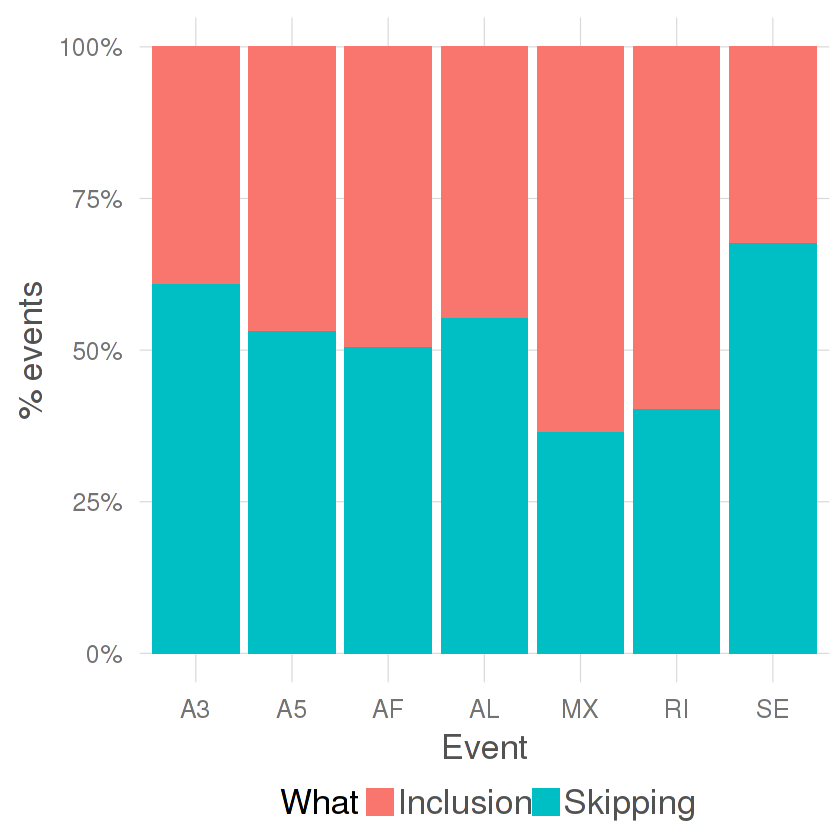

In [5]:
# compare inclusion and exclusion
events_switches %>%
    select(eventType, what) %>%
    group_by(eventType, what) %>%
    summarise(n = n()) %>%
    ggplot(aes(eventType, n, fill = what)) + 
        geom_bar(stat="identity", position="fill") +
        labs(x = "Event", y = "% events", fill = "What") +
        clean_theme() +
        scale_y_continuous(labels = percent)  +
        theme(legend.position="bottom")

In [6]:
# total number of switches
switches %>%
    select(Normal_transcript,Tumor_transcript) %>%
    unique %>%
    nrow

[1] 8122

Adding missing grouping variables: `Normal_transcript`, `Tumor_transcript`, `event_id`
Adding missing grouping variables: `Normal_transcript`, `Tumor_transcript`, `event_id`


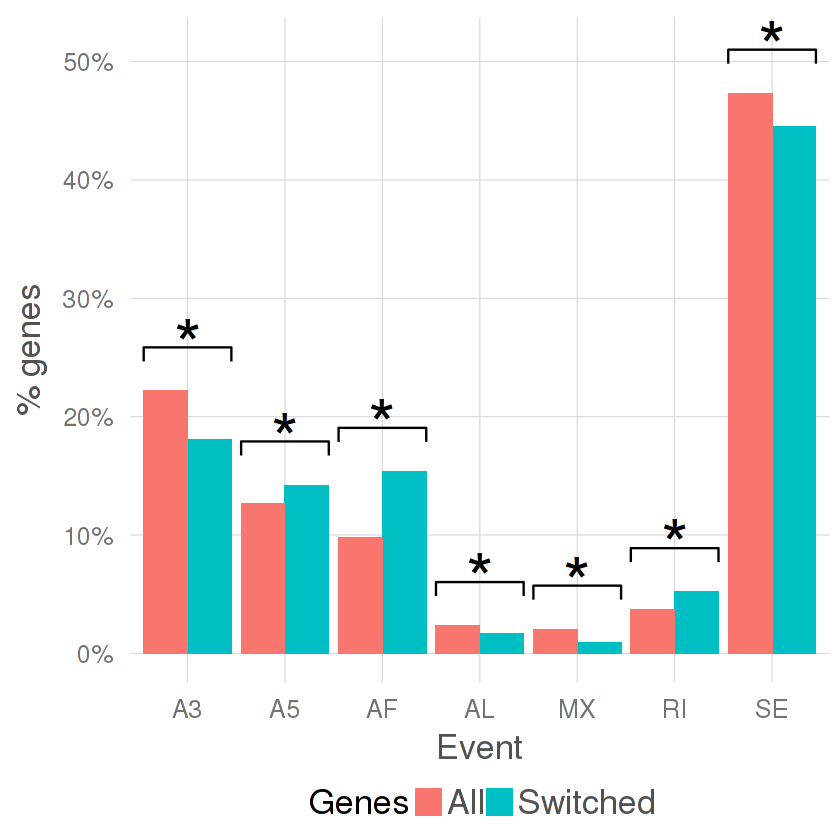

In [7]:
# compare proportions to background ie all events
events_switches.freq <- events_switches %>%
    select(eventType) %>%
    group_by(eventType) %>%
    summarise(., f = n()/nrow(.)) %>%
    mutate(Genes = "Switched")

events.freq <- events %>%
    select(eventType) %>%
    group_by(eventType) %>%
    summarise(., f = n()/nrow(.)) %>%
    mutate(Genes = "All")

# compare proportions to background ie all events
events_switches.n <- events_switches %>%
    select(eventType) %>%
    group_by(eventType) %>%
    summarise(f = n())

events.n <- events %>%
    select(eventType) %>%
    group_by(eventType) %>%
    summarise(f = n())

tests <- merge(events_switches.n, events.n, by="eventType", suffixes = c(".switches",".all")) %>%
    mutate(n.switches = sum(f.switches) - f.switches, 
           n.all = sum(f.all) - f.all)
p <- apply(tests %>% select(n.switches, f.switches, n.all, f.all), 1, function(x){
    fisher.test(matrix(x,2,2))$p.value
})

gg <- rbind(events.freq, events_switches.freq) %>%
    ggplot(aes(eventType, f, fill = Genes)) + 
        geom_bar(stat="identity", position="dodge") +
        labs(x = "Event", y = "% genes") +
        scale_y_continuous(labels = percent)  +
        clean_theme() +
        theme(legend.position="bottom")

star_bar(gg, p < 0.025, dist = 0.025, fit = FALSE)

Warning message:
“Transformation introduced infinite values in continuous x-axis”

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

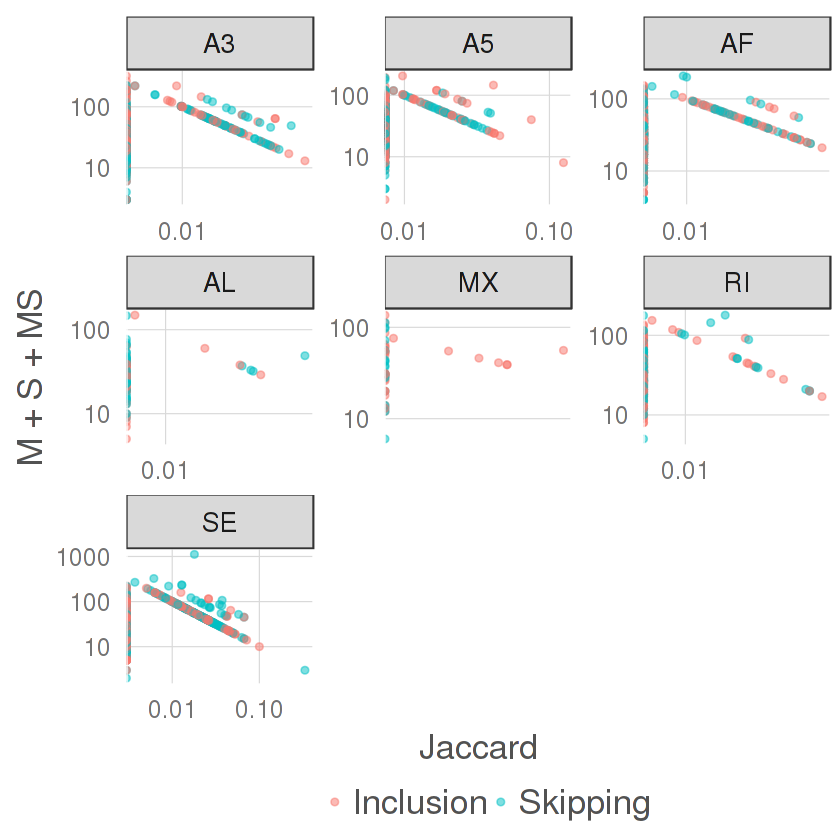

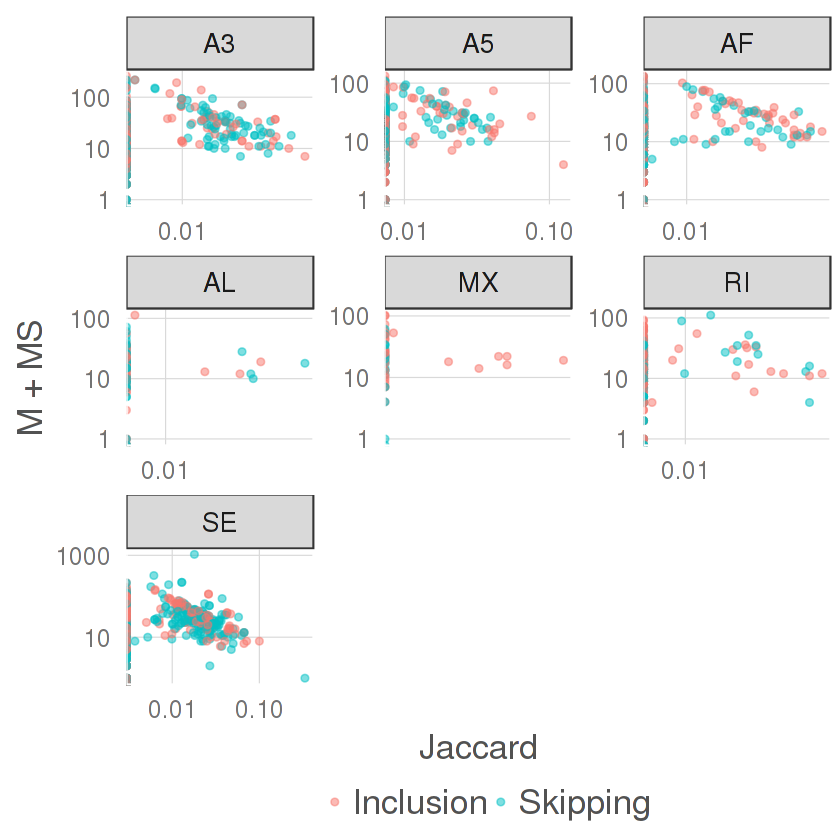

In [8]:
# check events that correlate with mutations in WES
merge(events_switches, wes) %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    ggplot(aes(x = Jaccard, y = M + S + MS, color = what)) +
        geom_point(alpha = 0.5) +
        clean_theme() + 
        theme(legend.position="bottom") +
        labs(color = "") +
        scale_x_log10() +
        scale_y_log10() +
        facet_wrap(~ eventType, scales = "free")

merge(events_switches, wes) %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    ggplot(aes(x = Jaccard, y = M + MS, color = what)) +
        geom_point(alpha = 0.5) +
        clean_theme() + 
        theme(legend.position="bottom") +
        labs(color = "") +
        scale_x_log10() +
        scale_y_log10() +
        facet_wrap(~ eventType, scales = "free")

Warning message:
“Transformation introduced infinite values in continuous x-axis”

Warning message:
“Transformation introduced infinite values in continuous x-axis”

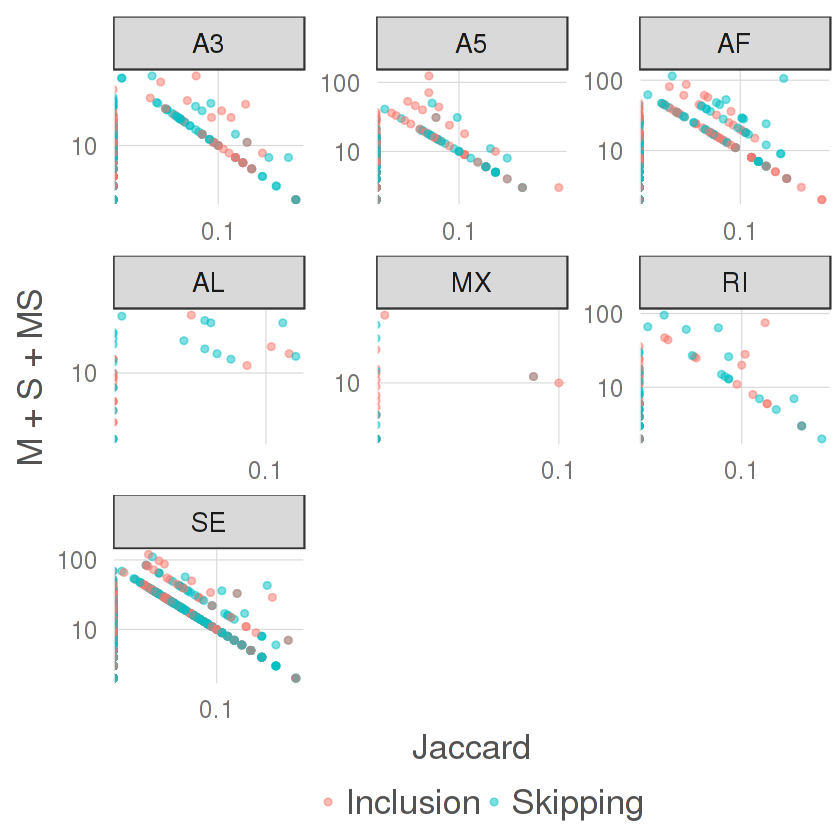

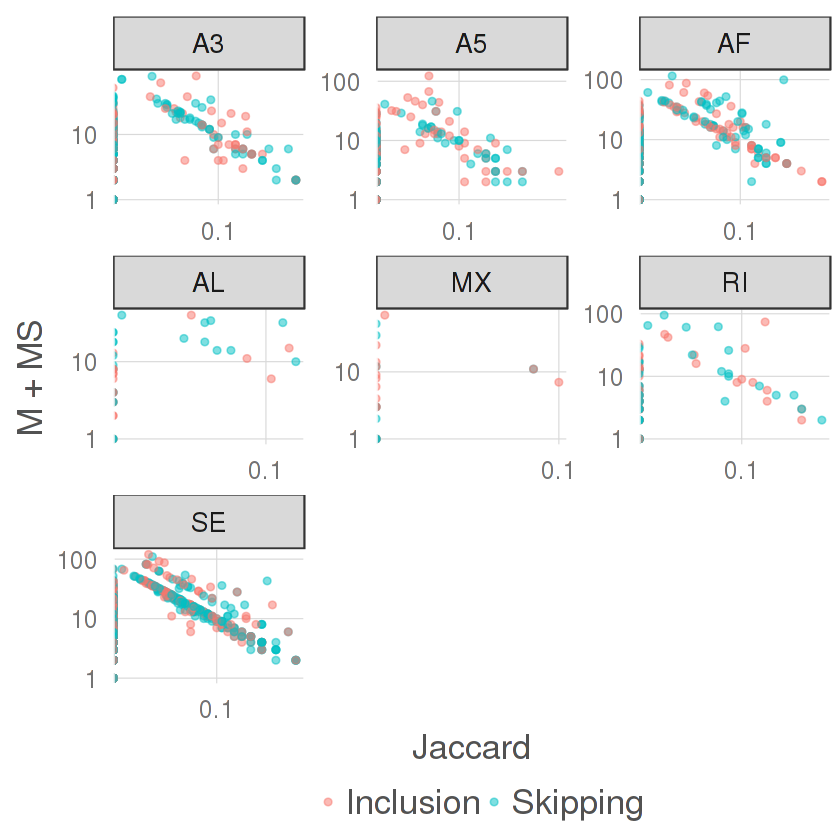

In [9]:
# check events that correlate with mutations in WGS
merge(events_switches, wgs) %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    ggplot(aes(x = Jaccard, y = M + S + MS, color = what)) +
        geom_point(alpha = 0.5) +
        clean_theme() + 
        theme(legend.position="bottom") +
        labs(color = "") +
        scale_x_log10() +
        scale_y_log10() +
        facet_wrap(~ eventType, scales = "free")

merge(events_switches, wgs) %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    ggplot(aes(x = Jaccard, y = M + MS, color = what)) +
        geom_point(alpha = 0.5) +
        clean_theme() + 
        theme(legend.position="bottom") +
        labs(color = "") +
        scale_x_log10() +
        scale_y_log10() +
        facet_wrap(~ eventType, scales = "free")

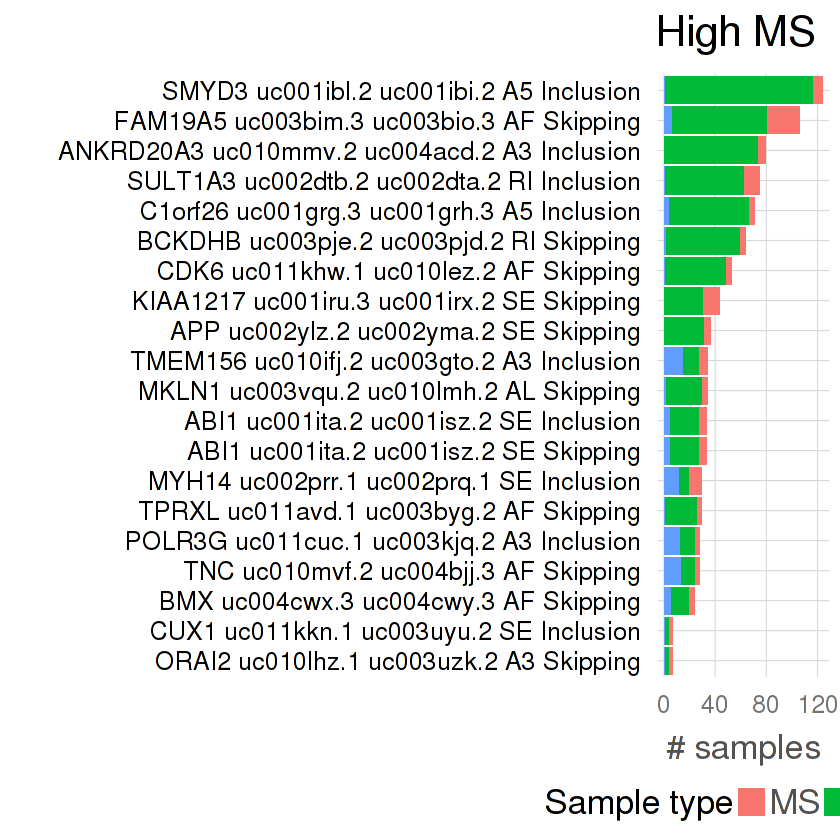

In [10]:
# plot cases with most MS
merge(events_switches, wgs) %>%
    arrange(MS) %>%
    tail(n=20) %>%
    arrange(MS + M + S) %>%
    mutate(event = paste(Symbol, Normal_transcript, Tumor_transcript, eventType, what),
           event = factor(event, levels=event)) %>%
    select(event,MS,M,S) %>%
    reshape2::melt(id.vars=c("event")) %>%
    subset(value!=0) %>%
    ggplot() + 
        geom_bar(aes(x=event,y=value, fill=variable),stat="identity") +
        coord_flip() +
        labs(x="", y="# samples", fill="Sample type", title="High MS") +
        clean_theme() +
        theme(text = element_text(size=20), legend.position="bottom", 
              axis.text.y=element_text(hjust=1,vjust=0.5,colour="black"))    

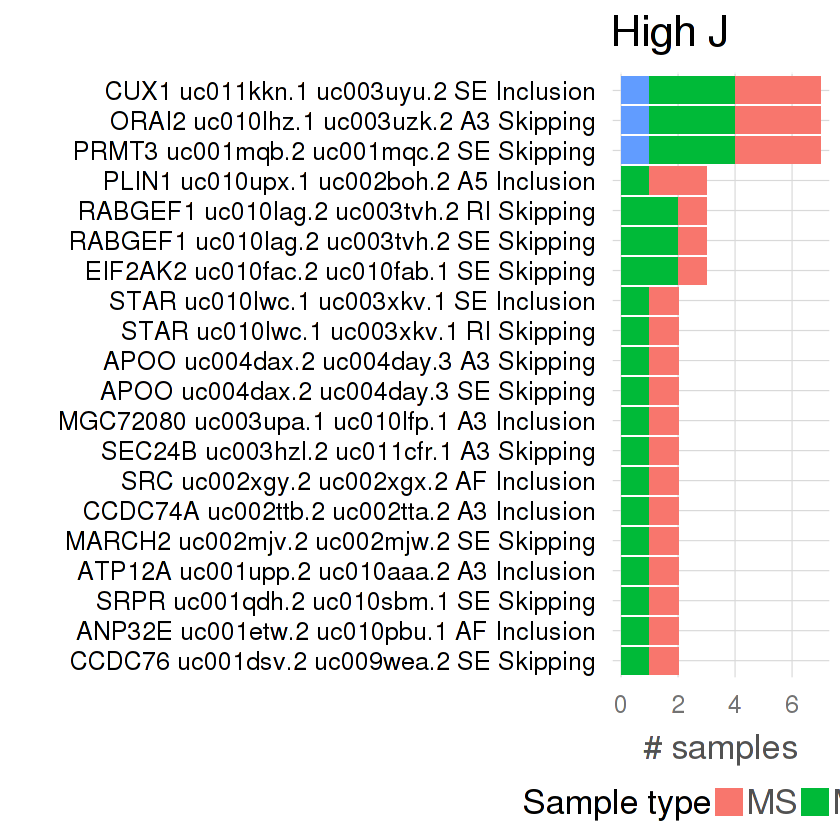

In [11]:
# plot cases with most MS
merge(events_switches, wgs) %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    arrange(Jaccard) %>%
    tail(n=20) %>%
    arrange(MS + M + S) %>%
    mutate(event = paste(Symbol, Normal_transcript, Tumor_transcript, eventType, what),
           event = factor(event, levels=event)) %>%
    select(event,MS,M,S) %>%
    reshape2::melt(id.vars=c("event")) %>%
    subset(value!=0) %>%
    ggplot() + 
        geom_bar(aes(x=event,y=value, fill=variable),stat="identity") +
        coord_flip() +
        labs(x="", y="# samples", fill="Sample type", title="High J") +
        clean_theme() +
        theme(text = element_text(size=20), legend.position="bottom", 
              axis.text.y=element_text(hjust=1,vjust=0.5,colour="black"))    